In [1]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as BS
from selenium import webdriver
from selenium.webdriver.common.by import By
from time import sleep

In [2]:
# Инициализация chrome webdriver
driver = webdriver.Chrome()
data = []

try:
    for i in range(1, 11):
        # Загрузка страницы
        driver.get("https://www.kinopoisk.ru/lists/movies/top500/?page=" + str(i))
        # Ждём, пока загрузится заголовок при динамическом исполнении JS
        driver.implicitly_wait(10)
#         time.sleep(10)
        # Selenium может извлечь динамически загруженные элементы
        soup = BS(driver.page_source, "html.parser")
        films = soup.find_all(class_='styles_upper__j8BIs')
        for film in films:
            name = film.find(class_="styles_mainTitle__IFQyZ styles_activeMovieTittle__kJdJj").text
            rating = film.find(class_='styles_kinopoiskValue__nkZEC').text
            rating_count = film.find('span', class_='styles_kinopoiskCount__PT7ZX').text
            desc = film.find(class_='desktop-list-main-info_additionalInfo__Hqzof').text
            date_time = film.find(class_='desktop-list-main-info_secondaryText__M_aus').text
            link = "https://www.kinopoisk.ru" + film.find('a', class_="base-movie-main-info_link__YwtP1").get('href')
            data.append((name, rating, rating_count, desc, date_time, link))
finally:
    print(data)
    

driver.quit()


[('1+1', '8.3', '558 254', 'Франция • драма\xa0\xa0Режиссёр: Оливье Накаш', ', 2011, 1 ч 52 мин', 'https://www.kinopoisk.ru/film/535341/'), ('Интерстеллар', '8.2', '105 607', 'США • фантастика\xa0\xa0Режиссёр: Кристофер Нолан', ', 2014, 2 ч 49 мин', 'https://www.kinopoisk.ru/film/258687/'), ('Зеленая миля', '8.1', '90 056', 'США • драма\xa0\xa0Режиссёр: Фрэнк Дарабонт', ', 1999, 3 ч 9 мин', 'https://www.kinopoisk.ru/film/435/'), ('Побег из Шоушенка', '8.1', '89 611', 'США • драма\xa0\xa0Режиссёр: Фрэнк Дарабонт', ', 1994, 2 ч 22 мин', 'https://www.kinopoisk.ru/film/326/'), ('Бойцовский клуб', '8.1', '198 488', 'США • триллер\xa0\xa0Режиссёр: Дэвид Финчер', ', 1999, 2 ч 19 мин', 'https://www.kinopoisk.ru/film/361/'), ('Остров проклятых', '8.1', '204 318', 'США • триллер\xa0\xa0Режиссёр: Мартин Скорсезе', ', 2009, 2 ч 18 мин', 'https://www.kinopoisk.ru/film/397667/'), ('Форрест Гамп', '8.1', '79 051', 'США • драма\xa0\xa0Режиссёр: Роберт Земекис', ', 1994, 2 ч 22 мин', 'https://www.kinop

In [3]:
df = pd.DataFrame(data, columns=['Name', 'Rating', 'Rating count', 'Description', 'Year_Time', 'Link'])

In [4]:
df['Country'] = df['Description'].str.split('•').apply(lambda x : x[0])
df['Genre'] = df['Description'].str.split('•').apply(lambda x : x[1].split()[0])
df['Director'] = df['Description'].str.split('•').apply(lambda x : x[1].split('Режиссёр:')[1])
df['Year'] = df['Year_Time'].str.split(',').apply(lambda x : x[-2])
df['Time'] = df['Year_Time'].str.split(',').apply(lambda x : x[-1])


In [5]:
df['Rating'] = df['Rating'].astype('float')
df['Rating count'] = df['Rating count'].str.replace(' ', '').astype('int')
df['Year'] = df['Year'].astype('int')
df['Genre'] = df['Genre'].astype('category')

def convert_time(t):
    res = 0
    if 'ч' in t:
        res += int(t.split('ч')[0]) * 60
    if 'мин' in t:
        res += int(t.split('мин')[0].split()[-1])
    return res
        
df['Time'] = df['Time'].apply(convert_time)

In [6]:
df.drop(columns=['Description', 'Year_Time'], inplace=True)

In [7]:
df.rename(columns={'Time': 'Time (min)'}, inplace=True)

In [8]:
df

,Name,Rating,Rating count,Link,Country,Genre,Director,Year,Time (min)
0,1+1,8.3,558254,https://www.kinopoisk.ru/film/535341/,Франция,драма,Оливье Накаш,2011,112
1,Интерстеллар,8.2,105607,https://www.kinopoisk.ru/film/258687/,США,фантастика,Кристофер Нолан,2014,169
2,Зеленая миля,8.1,90056,https://www.kinopoisk.ru/film/435/,США,драма,Фрэнк Дарабонт,1999,189
3,Побег из Шоушенка,8.1,89611,https://www.kinopoisk.ru/film/326/,США,драма,Фрэнк Дарабонт,1994,142
4,Бойцовский клуб,8.1,198488,https://www.kinopoisk.ru/film/361/,США,триллер,Дэвид Финчер,1999,139
...,...,...,...,...,...,...,...,...,...
495,Бесстрашный,6.9,24180,https://www.kinopoisk.ru/film/102161/,Китай,боевик,Ронни Юй,2006,104
496,Талантливый мистер Рипли,6.9,11285,https://www.kinopoisk.ru/film/5558/,США,триллер,Энтони Мингелла,1999,139
497,1408,6.9,16859,https://www.kinopoisk.ru/film/195563/,США,ужасы,Микаэль Хофстрём,2007,104
498,Гадкий я,6.9,139378,https://www.kinopoisk.ru/film/432724/,США,мультфильм,Пьер Коффан,2010,95


In [9]:
df.describe()

,Rating,Rating count,Year,Time (min)
count,500.000000,500.000000,500.000000,500.00000
mean,7.224000,59005.894000,2003.318000,121.65600
std,0.250018,64819.382525,14.353289,24.72165
min,6.900000,5155.000000,1956.000000,46.00000
25%,7.000000,23465.250000,1997.000000,103.00000
50%,7.200000,37247.500000,2006.000000,120.00000
75%,7.300000,69864.750000,2014.000000,136.00000
max,8.300000,558254.000000,2024.000000,202.00000


In [10]:
# Узнаем сколько фильмов по странам
df['Country'].value_counts()

США                269
Великобритания      49
СССР                43
Россия              33
Япония              18
Франция             16
Германия            12
Новая Зеландия       8
Италия               7
Корея Южная          7
Испания              6
Канада               5
Дания                4
Австралия            4
Китай                3
Гонконг              3
Швеция               2
Ирландия             2
Беларусь             1
Мексика              1
Бразилия             1
Бельгия              1
Аргентина            1
Индия                1
ЮАР                  1
Норвегия             1
Казахстан            1
Name: Country, dtype: int64

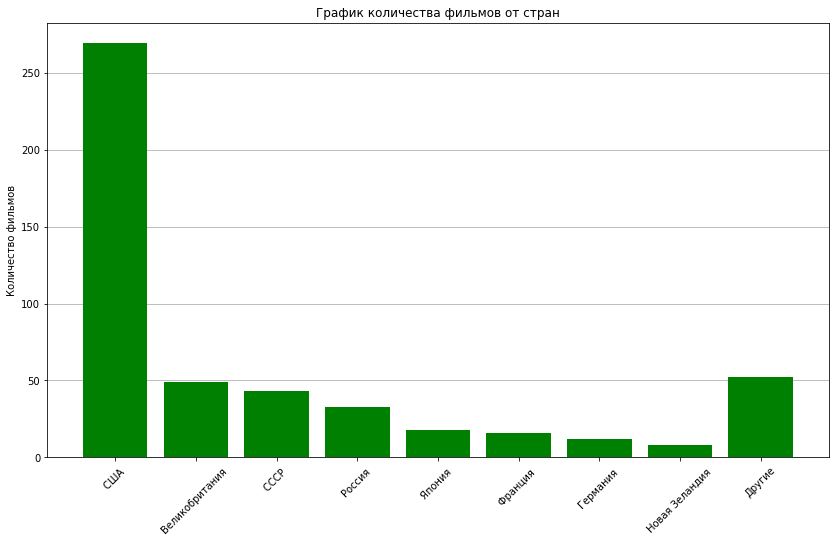

In [11]:
# Изобразим графически для наглядности

others = pd.Series(df['Country'].value_counts()[8:].sum(), index=['Другие'])
countries = pd.concat([df['Country'].value_counts()[:8], others])

plt.figure(figsize=(14, 8))
plt.grid(axis='y', zorder=0)
plt.bar(countries.index, countries, width=0.8, color='green', zorder=3)
plt.xticks(rotation=45)
plt.ylabel('Количество фильмов')
plt.title('График количества фильмов от стран')
plt.show()

In [12]:
# как видно довольно много фильмов из США

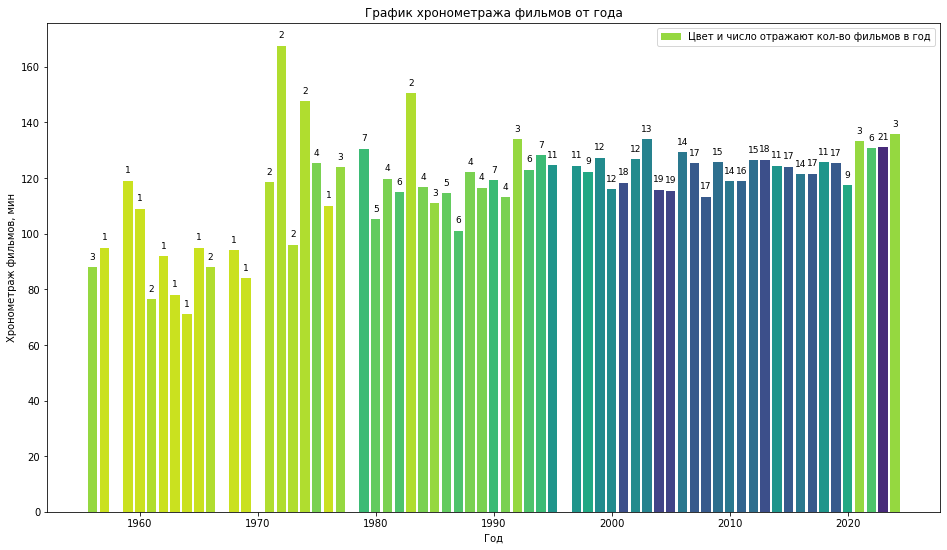

In [13]:

palette = sns.color_palette("viridis", 24)[::-1]

temp_df = df.groupby(['Year'])['Time (min)'].agg(['mean', 'count'])
fig, ax = plt.subplots(figsize=(16,9))
color = [palette[i] for i in temp_df['count']]

b = ax.bar(temp_df.index, temp_df['mean'], color=color, label='Цвет и число отражают кол-во фильмов в год')
ax.bar_label(b, labels=temp_df['count'],
             padding=6, fontsize=9)

ax.set_xlabel('Год')
ax.set_ylabel('Хронометраж фильмов, мин')
ax.set_title('График хронометража фильмов от года')
ax.legend()

plt.show()

In [14]:
# По количеству данных по годам можно условно разделить на три группы 1956 - 1977, 1979 - 1992, 1993 - 2024

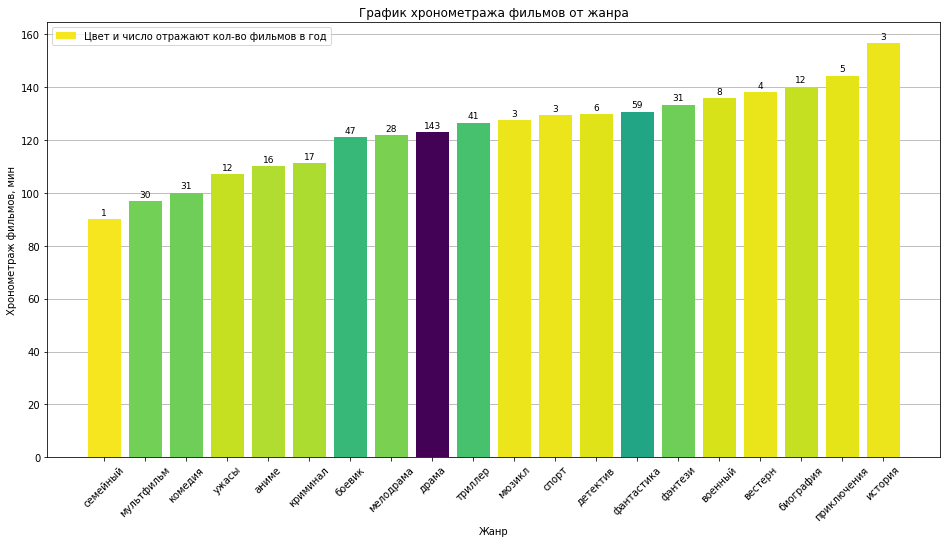

In [15]:
temp_df = df.groupby(['Genre'])['Time (min)'].agg(['mean', 'count']).sort_values(by='mean')
palette = sns.color_palette("viridis", temp_df['count'].max() + 1)[::-1]

fig, ax = plt.subplots(figsize=(16,8))
color = [palette[i] for i in temp_df['count']]


b = ax.bar(temp_df.index, temp_df['mean'], color=color, label='Цвет и число отражают кол-во фильмов в год', zorder=3)
ax.bar_label(b, labels=temp_df['count'],
             padding=2, fontsize=9)
plt.xticks(rotation=45)
# ax.set_xticklabels(temp_df.index, rotation=45)
ax.set_xlabel('Жанр')


ax.set_ylabel('Хронометраж фильмов, мин')
ax.set_title('График хронометража фильмов от жанра')
ax.legend(loc= 'upper left')
ax.grid(axis='y', zorder=0)
plt.show()

In [16]:
df.to_csv('kinopoist_top_500.csv', index=False)